In [1]:
import plotly
import pandas as pd

# Explore Covid-19 data across the US

This notebook explores the Covid-19 dataset available as part of Google BigQuery public data. This notebook explores two tables the us_states and the us_counties which contain the per data confirmed cases and deaths across states and counties.

We first install the neccessary Python packages needed for the analysis and then pull the data from BigQuery directly into a Python Pandas dataframe. The data is then analyzed using Pandas and visulized using Plotly.

## Install the dependencies

In [2]:
!pip install --upgrade google-cloud-bigquery[pandas]
!pip install plotly
!pip install seaborn

Requirement already up-to-date: google-cloud-bigquery[pandas] in /opt/conda/lib/python3.7/site-packages (1.25.0)


In [3]:
import plotly
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Download the data from BigQuery
We download the states data into a dataframe named covid_us_states and similarly for counties in a dataframe named covid_us_counties.

In [4]:
%%bigquery covid_us_states
SELECT
    *
FROM `bigquery-public-data.covid19_nyt.us_states`
ORDER BY date DESC

In [5]:
%%bigquery covid_us_counties
SELECT
    *
FROM `bigquery-public-data.covid19_nyt.us_counties`
ORDER BY date DESC

In [6]:
%%bigquery covid_us_states_daily_changes
SELECT
  *,
  LAG(deaths) OVER (PARTITION BY state_name ORDER BY date ASC) AS deaths_yesterday,
  (deaths-LAG(deaths) OVER (PARTITION BY state_name ORDER BY date ASC)) as new_deaths,
  LAG(confirmed_cases) OVER (PARTITION BY state_name ORDER BY date ASC) AS confirmed_cases_yesterday,
  (confirmed_cases-LAG(confirmed_cases) OVER (PARTITION BY state_name ORDER BY date ASC)) as new_confirmed_cases
FROM
  `bigquery-public-data.covid19_nyt.us_states`

## Let's explore the data a little bit

In [7]:
display(covid_us_states.sample(10))
covid_us_states.describe(include='all')

date  state_name state_fips_code  confirmed_cases  deaths
786   2020-06-22     Indiana              18            43709    2553
1760  2020-06-04        Guam              66             1148       6
1601  2020-06-07       Texas              48            75948    1846
5992  2020-03-19       Maine              23               52       0
2015  2020-05-31   Wisconsin              55            18418     594
685   2020-06-24    Maryland              24            65934    3108
1267  2020-06-13        Ohio              39            40848    2554
3938  2020-04-26   Minnesota              27             3602     272
2787  2020-05-17  New Jersey              34           146334   10356
495   2020-06-27        Guam              66             1217       6

date  state_name state_fips_code  confirmed_cases        deaths
count         6944        6944            6944      6944.000000   6944.000000
unique         168          55              55              NaN           NaN
top     2020-05-23  Washington              53              NaN           NaN
freq            55         168             168              NaN           NaN
mean           NaN         NaN             NaN     21378.262241   1149.383497
std            NaN         NaN             NaN     48298.182991   3434.437695
min            NaN         NaN             NaN         1.000000      0.000000
25%            NaN         NaN             NaN       479.000000      7.000000
50%            NaN         NaN             NaN      4317.000000    121.500000
75%            NaN         NaN             NaN     20364.000000    754.250000
max            NaN         NaN             NaN    402338.000000  31911.000000

In [8]:
display(covid_us_counties.sample(10))
covid_us_counties.describe(include='all')

date      county      state_name county_fips_code  \
224087  2020-04-22  Livingston        Michigan            26093   
99305   2020-06-04       Avery  North Carolina            37011   
160963  2020-05-14      Arenac        Michigan            26011   
242165  2020-04-16    Columbia       Wisconsin            55021   
265269  2020-04-07    Pontotoc        Oklahoma            40123   
93985   2020-06-06       Gregg           Texas            48183   
129425  2020-05-25       Osage        Oklahoma            40113   
190353  2020-05-04   Jefferson         Montana            30043   
65674   2020-06-15      Alcorn     Mississippi            28003   
119358  2020-05-28      Harvey          Kansas            20079   

        confirmed_cases  deaths  
224087              314      11  
99305                 2       0  
160963               29       1  
242165               27       1  
265269                9       0  
93985               312      10  
129425               94       8  
190353                2       0  
65674                30       1  
119358               15       2

date      county state_name county_fips_code  confirmed_cases  \
count       304095      304095     304095           300922    304095.000000   
unique         168        1817         55             3065              NaN   
top     2020-07-06  Washington      Texas            53061              NaN   
freq          3091        3259      22168              168              NaN   
mean           NaN         NaN        NaN              NaN       488.175448   
std            NaN         NaN        NaN              NaN      4081.633174   
min            NaN         NaN        NaN              NaN         0.000000   
25%            NaN         NaN        NaN              NaN         6.000000   
50%            NaN         NaN        NaN              NaN        29.000000   
75%            NaN         NaN        NaN              NaN       140.000000   
max            NaN         NaN        NaN              NaN    221882.000000   

               deaths  
count   304095.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean        26.245874  
std        356.488588  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          4.000000  
max      22672.000000

In [9]:
covid_us_counties['county'] = covid_us_counties.apply(lambda row: row['county'] + ", " + row['state_name'], axis=1)
covid_us_counties['county_fips_code'] = covid_us_counties['county_fips_code'].map(lambda x: int(x) if x is not None else 0)

In [10]:
covid_us_counties.head()

date                   county state_name  county_fips_code  \
0  2020-07-06         Joplin, Missouri   Missouri                 0   
1  2020-07-06    Kansas City, Missouri   Missouri                 0   
2  2020-07-06  New York City, New York   New York                 0   
3  2020-07-06            Unknown, Guam       Guam                 0   
4  2020-07-06            Unknown, Iowa       Iowa                 0   

   confirmed_cases  deaths  
0              211       9  
1             2748      34  
2           221882   22672  
3             1270       6  
4               17       0

## Time for some plots

In [11]:
covid_us_counties_latest = covid_us_counties[covid_us_counties['date']==max(covid_us_counties['date'])]
covid_us_states_latest = covid_us_states[covid_us_states['date']==max(covid_us_states['date'])]
covid_us_states_latest = covid_us_states_latest.sort_values(by="confirmed_cases", ascending=False)
covid_us_counties_latest = covid_us_counties_latest.sort_values(by="confirmed_cases", ascending=False)
TOP_N = 20
covid_us_counties_latest_top_n = covid_us_counties_latest[:TOP_N]

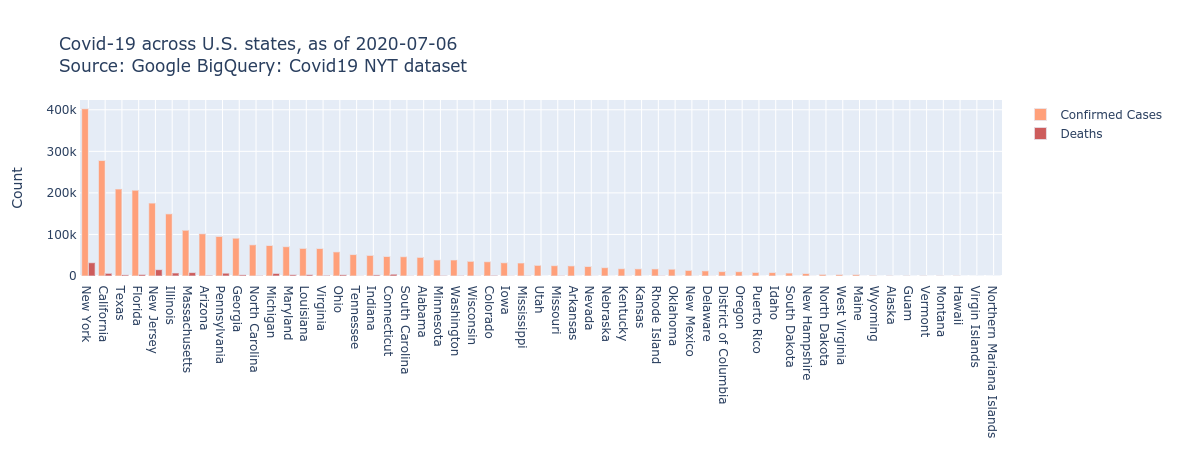

In [12]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=covid_us_states_latest['state_name'],
    y=covid_us_states_latest['confirmed_cases'],
    name='Confirmed Cases',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=covid_us_states_latest['state_name'],
    y=covid_us_states_latest['deaths'],
    name='Deaths',
    marker_color='indianred'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group',
                  title=f"Covid-19 across U.S. states, as of {covid_us_states_latest.iloc[0]['date']}<br>Source: Google BigQuery: Covid19 NYT dataset",
                  yaxis_title="Count")
fig.show()

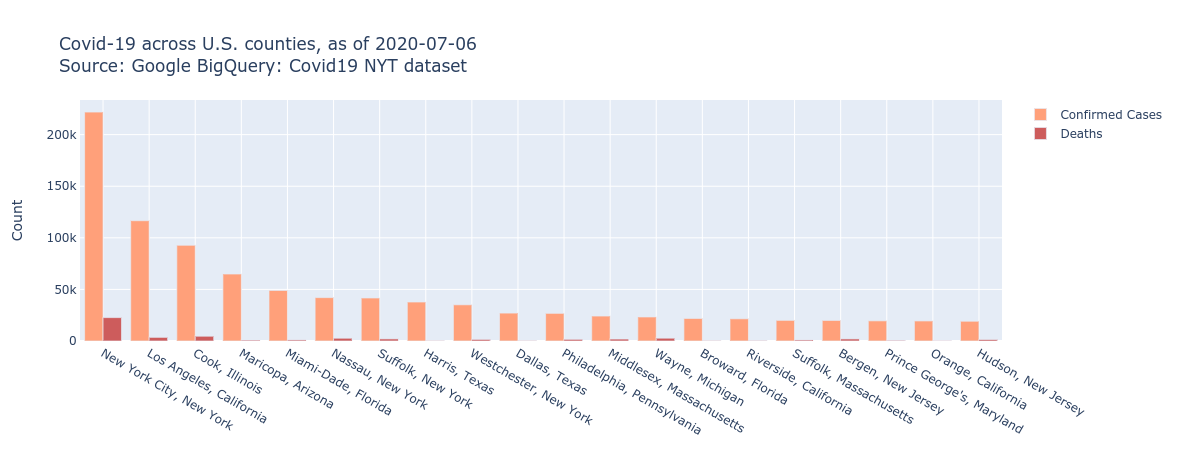

In [13]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=covid_us_counties_latest_top_n['county'],
    y=covid_us_counties_latest_top_n['confirmed_cases'],
    name='Confirmed Cases',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=covid_us_counties_latest_top_n['county'],
    y=covid_us_counties_latest_top_n['deaths'],
    name='Deaths',
    marker_color='indianred'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group',
                  title=f"Covid-19 across U.S. counties, as of {covid_us_counties_latest_top_n.iloc[0]['date']}<br>Source: Google BigQuery: Covid19 NYT dataset",
                  yaxis_title="Count")
fig.show()

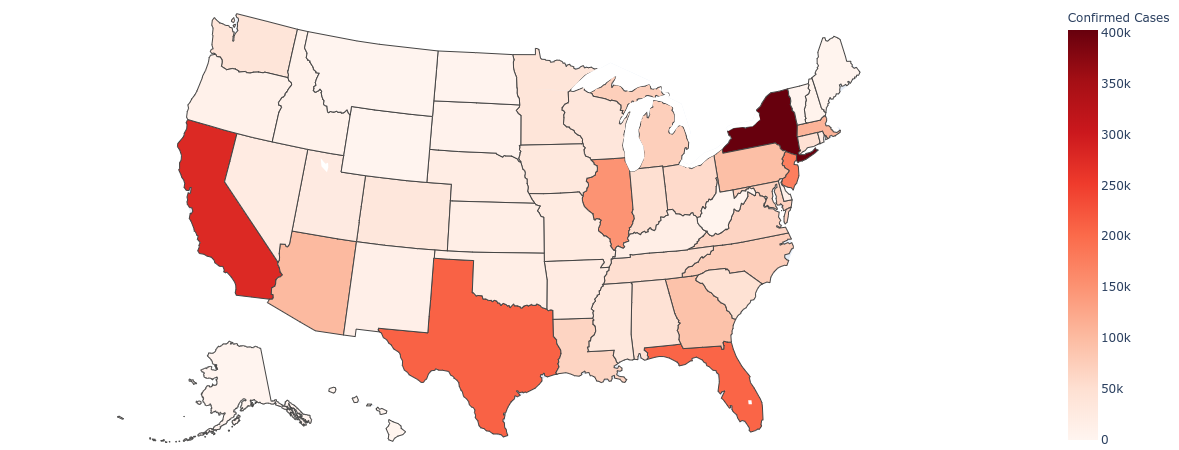

In [14]:
from urllib.request import urlopen
import plotly.express as px

import json

with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states = json.load(response)



fig = px.choropleth(covid_us_states_latest, geojson=states, locations='state_fips_code', color='confirmed_cases',
                           #color_continuous_scale=px.colors.sequential.Plasma,
                           color_continuous_scale="Reds",
                           range_color=(0, max(covid_us_states['confirmed_cases'])),
                           scope="usa",
                           hover_name="state_name",
                           labels={'confirmed_cases':'Confirmed Cases'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [15]:
states_census = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#")
display(states_census.head(10))

SUMLEV REGION DIVISION  STATE              NAME  CENSUS2010POP  \
0      10      0        0      0     United States      308745538   
1      20      1        0      0  Northeast Region       55317240   
2      20      2        0      0    Midwest Region       66927001   
3      20      3        0      0      South Region      114555744   
4      20      4        0      0       West Region       71945553   
5      40      3        6      1           Alabama        4779736   
6      40      4        9      2            Alaska         710231   
7      40      4        8      4           Arizona        6392017   
8      40      3        7      5          Arkansas        2915918   
9      40      4        9      6        California       37253956   

   ESTIMATESBASE2010  POPESTIMATE2010  POPESTIMATE2011  POPESTIMATE2012  ...  \
0          308758105        309321666        311556874        313830990  ...   
1           55318443         55380134         55604223         55775216  ...   
2           66929725         66974416         67157800         67336743  ...   
3          114563030        114866680        116006522        117241208  ...   
4           71946907         72100436         72788329         73477823  ...   
5            4780125          4785437          4799069          4815588  ...   
6             710249           713910           722128           730443  ...   
7            6392288          6407172          6472643          6554978  ...   
8            2916031          2921964          2940667          2952164  ...   
9           37254519         37319502         37638369         37948800  ...   

   RDOMESTICMIG2019  RNETMIG2011  RNETMIG2012  RNETMIG2013  RNETMIG2014  \
0          0.000000     2.493773     2.682083     2.636187     2.921500   
1         -5.254530     0.887909    -0.038355    -0.469783    -0.986097   
2         -2.365881    -0.963930    -0.973943    -0.006924    -0.762969   
3          3.261349     5.130513     5.850458     5.292073     6.161501   
4          0.614245     2.723344     3.062896     3.162262     4.026429   
5          1.917501     0.578434     1.186314     1.522549     0.563489   
6        -12.929847     0.587728     1.416798    -0.955359   -11.460949   
7         12.609078     4.278167     6.899802     6.376679     9.168478   
8          0.834503     3.294766     0.827785     0.057853    -0.091449   
9         -5.151429     1.276797     1.495016     1.649031     2.203551   

   RNETMIG2015  RNETMIG2016  RNETMIG2017  RNETMIG2018  RNETMIG2019  
0     3.260435     3.252788     2.871957     2.153911     1.818059  
1    -2.061965    -2.490484    -1.837048    -2.134447    -2.859713  
2    -1.388437    -1.241784    -0.557370    -0.922755    -1.111173  
3     7.277358     7.150074     6.198168     5.225519     5.203720  
4     4.987285     5.261078     4.021194     3.044951     2.312083  
5     0.626357     0.745172     1.090366     1.773786     2.483744  
6    -7.997118    -3.897349   -10.992765   -13.859140   -12.031221  
7     9.597577    11.964782    10.878879    12.962934    13.687161  
8     1.075446     1.486269     2.009593     0.958896     0.923429  
9     1.984957     0.500044    -0.629909    -2.130954    -3.276681  

[10 rows x 151 columns]

In [16]:
covid_us_states_latest_w_census_data = covid_us_states_latest.merge(states_census[['POPESTIMATE2019', 'NAME']], how="left", left_on="state_name", right_on="NAME")
covid_us_states_latest_w_census_data = covid_us_states_latest_w_census_data.dropna()
covid_us_states_latest_w_census_data['deaths_per_10k'] = covid_us_states_latest_w_census_data.apply(lambda x: int(10000*(x['deaths']/x['POPESTIMATE2019'])), axis=1)
covid_us_states_latest_w_census_data['confirmed_cases_per_10k'] = covid_us_states_latest_w_census_data.apply(lambda x: int(10000*(x['confirmed_cases']/x['POPESTIMATE2019'])), axis=1)

covid_us_states_latest_w_census_data.head()

date  state_name state_fips_code  confirmed_cases  deaths  \
0  2020-07-06    New York              36           402338   31911   
1  2020-07-06  California              06           277869    6452   
2  2020-07-06       Texas              48           209319    2726   
3  2020-07-06     Florida              12           206439    3777   
4  2020-07-06  New Jersey              34           175467   15229   

   POPESTIMATE2019        NAME  deaths_per_10k  confirmed_cases_per_10k  
0       19453561.0    New York              16                      206  
1       39512223.0  California               1                       70  
2       28995881.0       Texas               0                       72  
3       21477737.0     Florida               1                       96  
4        8882190.0  New Jersey              17                      197

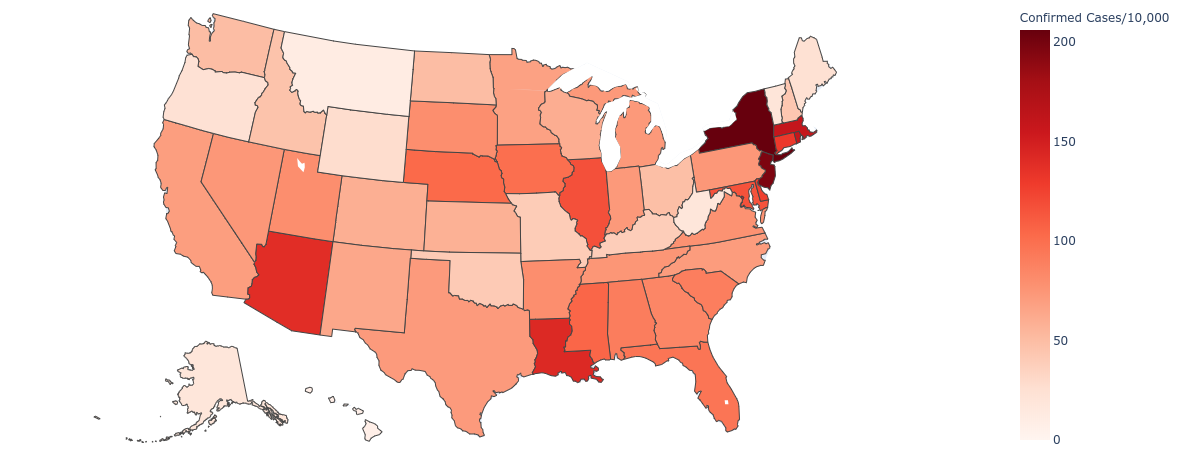

In [17]:
#CENSUS2010POP
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states = json.load(response)
fig = px.choropleth(covid_us_states_latest_w_census_data, geojson=states, locations='state_fips_code', color='confirmed_cases_per_10k',
                           #color_continuous_scale=px.colors.sequential.Plasma,
                           color_continuous_scale="Reds",
                           range_color=(0, max(covid_us_states_latest_w_census_data['confirmed_cases_per_10k'])),
                           scope="usa" ,
                           hover_name="state_name",
                           labels={'confirmed_cases_per_10k':'Confirmed Cases/10,000'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [23]:
covid_us_states_daily_changes

date state_name state_fips_code  confirmed_cases  deaths  \
0     2020-03-13    Alabama              01                6       0   
1     2020-03-14    Alabama              01               12       0   
2     2020-03-15    Alabama              01               23       0   
3     2020-03-16    Alabama              01               29       0   
4     2020-03-17    Alabama              01               39       0   
...          ...        ...             ...              ...     ...   
6939  2020-07-02    Wyoming              56             1550      20   
6940  2020-07-03    Wyoming              56             1582      20   
6941  2020-07-04    Wyoming              56             1606      20   
6942  2020-07-05    Wyoming              56             1634      20   
6943  2020-07-06    Wyoming              56             1675      20   

      deaths_yesterday  new_deaths  confirmed_cases_yesterday  \
0                  NaN         NaN                        NaN   
1                  0.0         0.0                        6.0   
2                  0.0         0.0                       12.0   
3                  0.0         0.0                       23.0   
4                  0.0         0.0                       29.0   
...                ...         ...                        ...   
6939              20.0         0.0                     1514.0   
6940              20.0         0.0                     1550.0   
6941              20.0         0.0                     1582.0   
6942              20.0         0.0                     1606.0   
6943              20.0         0.0                     1634.0   

      new_confirmed_cases  
0                     NaN  
1                     6.0  
2                    11.0  
3                     6.0  
4                    10.0  
...                   ...  
6939                 36.0  
6940                 32.0  
6941                 24.0  
6942                 28.0  
6943                 41.0  

[6944 rows x 9 columns]

In [24]:
covid_us_states_daily_changes_wide = covid_us_states_daily_changes[['date', 'state_name', 'new_confirmed_cases']].pivot(index='date', columns='state_name',values='new_confirmed_cases').reset_index(drop=True)
covid_us_states_wide = covid_us_states_daily_changes_wide.fillna(0)
covid_us_states_daily_changes_wide.to_csv('covid_us_states_daily_changes_wide.csv', index=False)
covid_us_states_daily_changes_wide = pd.read_csv('covid_us_states_daily_changes_wide.csv')
covid_us_states_daily_changes_wide

Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  \
0        NaN     NaN      NaN       NaN         NaN       NaN          NaN   
1        NaN     NaN      NaN       NaN         NaN       NaN          NaN   
2        NaN     NaN      NaN       NaN         NaN       NaN          NaN   
3        NaN     NaN      NaN       NaN         NaN       NaN          NaN   
4        NaN     NaN      NaN       NaN         NaN       NaN          NaN   
..       ...     ...      ...       ...         ...       ...          ...   
163   1149.0    50.0   3343.0     878.0      8434.0     323.0         74.0   
164   1754.0    60.0   4399.0     547.0      8100.0     272.0         71.0   
165    997.0    55.0   2722.0     587.0      8412.0     293.0          0.0   
166   1091.0    32.0   3510.0     605.0      6877.0     200.0          0.0   
167    925.0    30.0   3416.0     439.0      6282.0     216.0        259.0   

     Delaware  District of Columbia  Florida  ...  Tennessee   Texas   Utah  \
0         NaN                   NaN      NaN  ...        NaN     NaN    NaN   
1         NaN                   NaN      NaN  ...        NaN     NaN    NaN   
2         NaN                   NaN      NaN  ...        NaN     NaN    NaN   
3         NaN                   NaN      NaN  ...        NaN     NaN    NaN   
4         NaN                   NaN      NaN  ...        NaN     NaN    NaN   
..        ...                   ...      ...  ...        ...     ...    ...   
163     221.0                  25.0  10109.0  ...     1816.0  7434.0  602.0   
164     192.0                  45.0   9488.0  ...     1706.0  7158.0  604.0   
165      73.0                  12.0  11458.0  ...     1350.0  6289.0  647.0   
166     132.0                  35.0  10059.0  ...     1133.0  4431.0  288.0   
167     165.0                  33.0   6336.0  ...     1144.0  9181.0  648.0   

     Vermont  Virgin Islands  Virginia  Washington  West Virginia  Wisconsin  \
0        NaN             NaN       NaN         NaN            NaN        NaN   
1        NaN             NaN       NaN         0.0            NaN        NaN   
2        NaN             NaN       NaN         0.0            NaN        NaN   
3        NaN             NaN       NaN         0.0            NaN        NaN   
4        NaN             NaN       NaN         0.0            NaN        NaN   
..       ...             ...       ...         ...            ...        ...   
163     17.0             8.0     532.0       663.0           74.0      569.0   
164      9.0            13.0     658.0       496.0           73.0      689.0   
165      2.0             0.0     716.0       382.0           79.0      678.0   
166     11.0             1.0     639.0       669.0          130.0      507.0   
167      2.0             0.0     354.0      1049.0          107.0      568.0   

     Wyoming  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
..       ...  
163     36.0  
164     32.0  
165     24.0  
166     28.0  
167     41.0  

[168 rows x 55 columns]

In [25]:
covid_us_states_daily_changes_wide.columns

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota',
       'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'],
      dtype='object')

In [26]:
overall_pearson_r = covid_us_states_daily_changes_wide.corr()
overall_pearson_r

Alabama    Alaska   Arizona  Arkansas  California  \
Alabama                   1.000000  0.708332  0.732161  0.790367    0.847448   
Alaska                    0.708332  1.000000  0.820223  0.748506    0.810051   
Arizona                   0.732161  0.820223  1.000000  0.825910    0.892383   
Arkansas                  0.790367  0.748506  0.825910  1.000000    0.844019   
California                0.847448  0.810051  0.892383  0.844019    1.000000   
Colorado                 -0.121338 -0.180165 -0.072327 -0.136217    0.077769   
Connecticut              -0.326794 -0.359057 -0.369850 -0.376627   -0.273215   
Delaware                  0.052638 -0.136376 -0.063345 -0.044314    0.069082   
District of Columbia     -0.259066 -0.413592 -0.317143 -0.322516   -0.166852   
Florida                   0.750631  0.812712  0.864414  0.772469    0.870159   
Georgia                   0.731653  0.764317  0.779394  0.718393    0.887313   
Guam                     -0.134908 -0.028888 -0.147247 -0.176960   -0.152033   
Hawaii                    0.103426  0.436890  0.266555  0.153281    0.188622   
Idaho                     0.667711  0.752442  0.773080  0.651542    0.832272   
Illinois                 -0.133432 -0.363776  0.040593 -0.238567    0.271881   
Indiana                   0.106330 -0.065504  0.077785  0.035624    0.232817   
Iowa                      0.383445  0.181544  0.322450  0.360594    0.457877   
Kansas                    0.453481  0.215050  0.366782  0.268601    0.486352   
Kentucky                  0.389908  0.309585  0.406211  0.373148    0.473735   
Louisiana                 0.278919  0.409233  0.372628  0.249448    0.404237   
Maine                     0.264617  0.103634  0.136854  0.200518    0.183712   
Maryland                 -0.041537 -0.276155 -0.119559 -0.092620    0.071721   
Massachusetts            -0.325700 -0.394614 -0.171037 -0.390178    0.017358   
Michigan                 -0.231964 -0.057440 -0.191956 -0.253239   -0.131224   
Minnesota                 0.314375 -0.007912  0.254954  0.242793    0.375762   
Mississippi               0.645172  0.577841  0.590092  0.625519    0.772507   
Missouri                  0.652224  0.679823  0.687891  0.632645    0.758445   
Montana                   0.626326  0.753485  0.640620  0.540201    0.687956   
Nebraska                  0.127820 -0.170246  0.151273  0.041254    0.325130   
Nevada                    0.780355  0.792827  0.842185  0.742155    0.866062   
New Hampshire            -0.165100 -0.288637 -0.166883 -0.234845   -0.016623   
New Jersey               -0.424067 -0.306216 -0.374983 -0.474099   -0.294666   
New Mexico                0.533972  0.416912  0.520200  0.533216    0.651258   
New York                 -0.482375 -0.261962 -0.379214 -0.508177   -0.332648   
North Carolina            0.834978  0.714952  0.837282  0.878681    0.863954   
North Dakota              0.231323 -0.012749  0.129849  0.204793    0.255400   
Northern Mariana Islands -0.160365 -0.045654 -0.148983 -0.137289   -0.136757   
Ohio                      0.525894  0.401351  0.529998  0.483282    0.660811   
Oklahoma                  0.735753  0.776213  0.866951  0.782075    0.862518   
Oregon                    0.730264  0.750779  0.843448  0.753019    0.846950   
Pennsylvania             -0.185540 -0.219818 -0.189410 -0.243630   -0.047008   
Puerto Rico               0.318052  0.297540  0.372760  0.341465    0.356358   
Rhode Island             -0.280704 -0.435573 -0.303357 -0.322208   -0.127004   
South Carolina            0.843380  0.848032  0.929798  0.858721    0.932432   
South Dakota              0.105888 -0.066720  0.033618  0.038633    0.111198   
Tennessee                 0.773917  0.701916  0.752091  0.716670    0.852760   
Texas                     0.809406  0.795580  0.915034  0.809085    0.936335   
Utah                      0.822573  0.770231  0.854941  0.860138    0.900519   
Vermont                  -0.226290  0.063322 -0.196402 -0.194249   -0.198739   
Virgin Islands            0

In [27]:
overall_pearson_r.style.background_gradient(cmap='coolwarm')

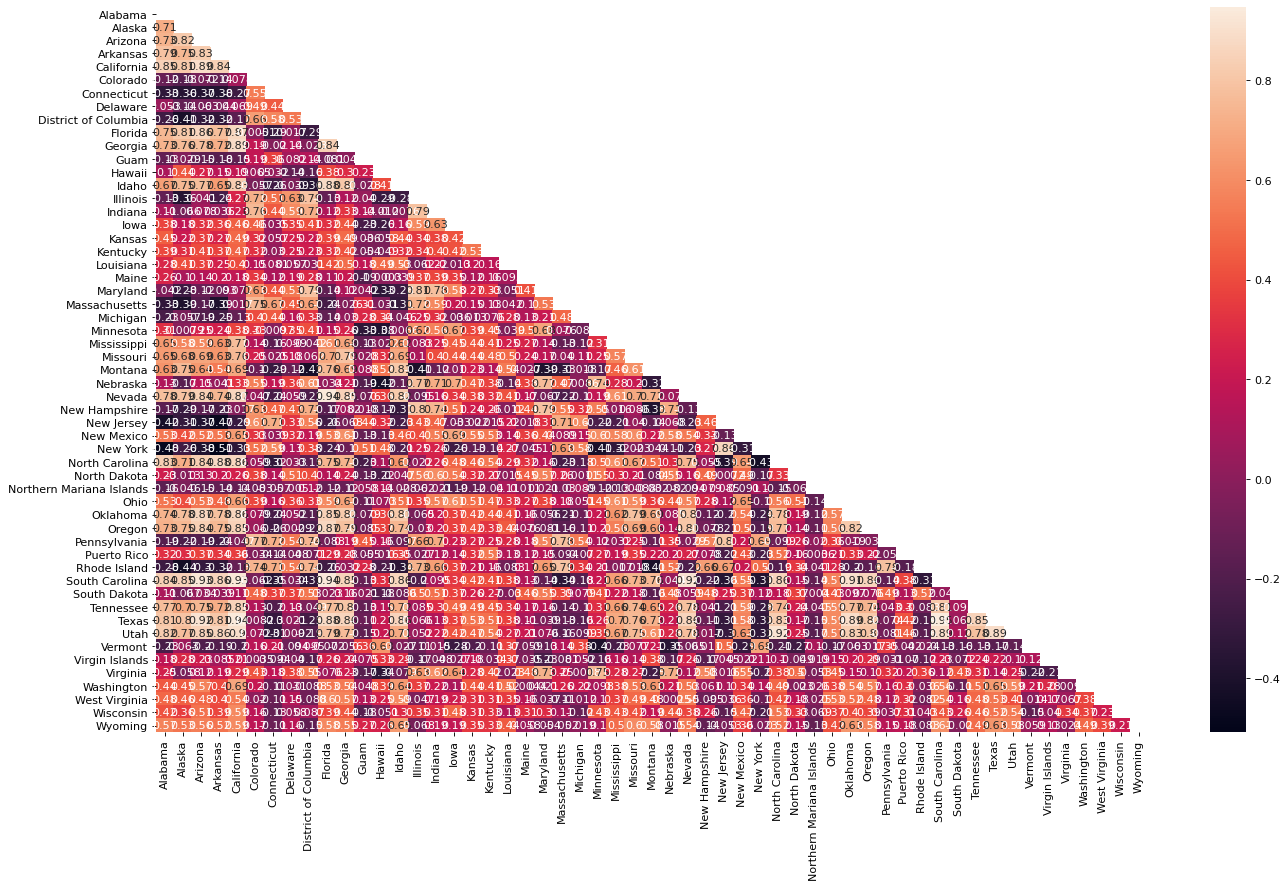

In [31]:
#sns.heatmap(overall_pearson_r)
import numpy as np
fig=plt.figure(figsize=(20, 12), dpi= 80, facecolor='w', edgecolor='k')

matrix = np.triu(overall_pearson_r)
sns.heatmap(overall_pearson_r, annot=True, mask=matrix)

In [47]:
us_states_governers = pd.read_csv("us_states_governers.csv")
#us_states_governers['State'] = us_states_red_blue['State'].map(lambda x: x.replace('_', ' '))
                                                              
#us_states_governers.to_csv("us_states_governers.csv", index=False)
#us_states_governers = pd.read_csv("us_states_governers.csv")
us_states_governers.head()

State    Governor
0   California  Democratic
1     Colorado  Democratic
2  Connecticut  Democratic
3     Delaware  Democratic
4       Hawaii  Democratic

In [48]:
covid_us_states_daily_changes = covid_us_states_daily_changes.merge(us_states_governers, how='left', left_on='state_name', right_on='State')
covid_us_states_daily_changes

date state_name state_fips_code  confirmed_cases  deaths  \
0     2020-03-13    Alabama              01                6       0   
1     2020-03-14    Alabama              01               12       0   
2     2020-03-15    Alabama              01               23       0   
3     2020-03-16    Alabama              01               29       0   
4     2020-03-17    Alabama              01               39       0   
...          ...        ...             ...              ...     ...   
6939  2020-07-02    Wyoming              56             1550      20   
6940  2020-07-03    Wyoming              56             1582      20   
6941  2020-07-04    Wyoming              56             1606      20   
6942  2020-07-05    Wyoming              56             1634      20   
6943  2020-07-06    Wyoming              56             1675      20   

      deaths_yesterday  new_deaths  confirmed_cases_yesterday  \
0                  NaN         NaN                        NaN   
1                  0.0         0.0                        6.0   
2                  0.0         0.0                       12.0   
3                  0.0         0.0                       23.0   
4                  0.0         0.0                       29.0   
...                ...         ...                        ...   
6939              20.0         0.0                     1514.0   
6940              20.0         0.0                     1550.0   
6941              20.0         0.0                     1582.0   
6942              20.0         0.0                     1606.0   
6943              20.0         0.0                     1634.0   

      new_confirmed_cases    State    Governor  
0                     NaN  Alabama  Republican  
1                     6.0  Alabama  Republican  
2                    11.0  Alabama  Republican  
3                     6.0  Alabama  Republican  
4                    10.0  Alabama  Republican  
...                   ...      ...         ...  
6939                 36.0  Wyoming  Republican  
6940                 32.0  Wyoming  Republican  
6941                 24.0  Wyoming  Republican  
6942                 28.0  Wyoming  Republican  
6943                 41.0  Wyoming  Republican  

[6944 rows x 11 columns]

In [49]:
covid_us_states_daily_changes_red = covid_us_states_daily_changes[covid_us_states_daily_changes['Governor'] == 'Republican']
covid_us_states_daily_changes_red_wide = covid_us_states_daily_changes_red[['date', 'state_name', 'new_confirmed_cases']].pivot(index='date', columns='state_name',values='new_confirmed_cases').reset_index(drop=True)
covid_us_states_daily_changes_red_wide = covid_us_states_daily_changes_red_wide.fillna(0)
covid_us_states_daily_changes_red_wide.to_csv('covid_us_states_daily_changes_red_wide.csv', index=False)
covid_us_states_daily_changes_red_wide = pd.read_csv('covid_us_states_daily_changes_red_wide.csv')
covid_us_states_daily_changes_red_wide

Alabama  Alaska  Arizona  Arkansas  Florida  Georgia  Idaho  Indiana  \
0        0.0     0.0      0.0       0.0      0.0      0.0    0.0      0.0   
1        0.0     0.0      0.0       0.0      0.0      0.0    0.0      0.0   
2        0.0     0.0      0.0       0.0      0.0      0.0    0.0      0.0   
3        0.0     0.0      0.0       0.0      0.0      0.0    0.0      0.0   
4        0.0     0.0      0.0       0.0      0.0      0.0    0.0      0.0   
..       ...     ...      ...       ...      ...      ...    ...      ...   
158   1149.0    50.0   3343.0     878.0  10109.0   2886.0  309.0    437.0   
159   1754.0    60.0   4399.0     547.0   9488.0   2604.0  346.0    546.0   
160    997.0    55.0   2722.0     587.0  11458.0   2513.0  397.0    529.0   
161   1091.0    32.0   3510.0     605.0  10059.0   1897.0  368.0    575.0   
162    925.0    30.0   3416.0     439.0   6336.0   1526.0  423.0    357.0   

      Iowa  Maryland  ...    Ohio  Oklahoma  South Carolina  South Dakota  \
0      0.0       0.0  ...     0.0       0.0             0.0           0.0   
1      0.0       0.0  ...     0.0       0.0             0.0           0.0   
2      0.0       0.0  ...     0.0       0.0             0.0           0.0   
3      0.0       0.0  ...     0.0       0.0             0.0           0.0   
4      0.0       0.0  ...     0.0       0.0             0.0           0.0   
..     ...       ...  ...     ...       ...             ...           ...   
158  641.0     513.0  ...  1301.0     427.0          1782.0          67.0   
159  372.0     407.0  ...  1091.0     526.0          1831.0          85.0   
160  536.0     302.0  ...   926.0     580.0          1854.0          50.0   
161  445.0     233.0  ...   968.0     283.0          1461.0          35.0   
162  152.0     540.0  ...   805.0     434.0          1533.0          42.0   

     Tennessee   Texas   Utah  Vermont  West Virginia  Wyoming  
0          0.0     0.0    0.0      0.0            0.0      0.0  
1          0.0     0.0    0.0      0.0            0.0      0.0  
2          0.0     0.0    0.0      0.0            0.0      0.0  
3          0.0     0.0    0.0      0.0            0.0      0.0  
4          0.0     0.0    0.0      0.0            0.0      0.0  
..         ...     ...    ...      ...            ...      ...  
158     1816.0  7434.0  602.0     17.0           74.0     36.0  
159     1706.0  7158.0  604.0      9.0           73.0     32.0  
160     1350.0  6289.0  647.0      2.0           79.0     24.0  
161     1133.0  4431.0  288.0     11.0          130.0     28.0  
162     1144.0  9181.0  648.0      2.0          107.0     41.0  

[163 rows x 26 columns]

In [51]:
overall_pearson_r = covid_us_states_daily_changes_red_wide.corr()
overall_pearson_r

Alabama    Alaska   Arizona  Arkansas   Florida   Georgia  \
Alabama         1.000000  0.777196  0.775154  0.842576  0.788414  0.814246   
Alaska          0.777196  1.000000  0.847318  0.802435  0.840380  0.817512   
Arizona         0.775154  0.847318  1.000000  0.850677  0.877416  0.798131   
Arkansas        0.842576  0.802435  0.850677  1.000000  0.805891  0.788577   
Florida         0.788414  0.840380  0.877416  0.805891  1.000000  0.848206   
Georgia         0.814246  0.817512  0.798131  0.788577  0.848206  1.000000   
Idaho           0.727577  0.794311  0.806328  0.713193  0.897034  0.831256   
Indiana         0.466379  0.307721  0.288114  0.371734  0.314197  0.574907   
Iowa            0.586221  0.408628  0.449831  0.538315  0.446510  0.622809   
Maryland        0.326587  0.112545  0.105395  0.240279  0.086063  0.392704   
Massachusetts   0.041611 -0.067148 -0.145827 -0.059172 -0.075669  0.202067   
Mississippi     0.748565  0.678886  0.660037  0.717425  0.671906  0.779746   
Missouri        0.765739  0.752531  0.718437  0.728418  0.722312  0.859553   
Nebraska        0.390479  0.129028  0.222156  0.288960  0.173336  0.400830   
New Hampshire   0.251722  0.107635  0.048693  0.147927  0.043849  0.343626   
North Dakota    0.478371  0.263583  0.314492  0.422770  0.320366  0.502109   
Ohio            0.689983  0.572982  0.606181  0.631860  0.645511  0.790361   
Oklahoma        0.807495  0.826224  0.880066  0.832420  0.863268  0.861085   
South Carolina  0.871990  0.875898  0.937984  0.883938  0.946468  0.869290   
South Dakota    0.387316  0.218132  0.231753  0.298249  0.221491  0.435276   
Tennessee       0.839671  0.771670  0.781667  0.785478  0.798966  0.853480   
Texas           0.850431  0.836086  0.918643  0.846959  0.890326  0.875430   
Utah            0.875129  0.822722  0.862320  0.892057  0.807665  0.823326   
Vermont         0.045756  0.237530 -0.039291  0.031878  0.066787  0.165969   
West Virginia   0.661351  0.614837  0.593854  0.582157  0.675248  0.736540   
Wyoming         0.696872  0.642404  0.635457  0.644981  0.653549  0.691730   

                   Idaho   Indiana      Iowa  Maryland  ...      Ohio  \
Alabama         0.727577  0.466379  0.586221  0.326587  ...  0.689983   
Alaska          0.794311  0.307721  0.408628  0.112545  ...  0.572982   
Arizona         0.806328  0.288114  0.449831  0.105395  ...  0.606181   
Arkansas        0.713193  0.371734  0.538315  0.240279  ...  0.631860   
Florida         0.897034  0.314197  0.446510  0.086063  ...  0.645511   
Georgia         0.831256  0.574907  0.622809  0.392704  ...  0.790361   
Idaho           1.000000  0.295691  0.357779  0.069514  ...  0.608754   
Indiana         0.295691  1.000000  0.776338  0.864779  ...  0.777189   
Iowa            0.357779  0.776338  1.000000  0.734557  ...  0.759721   
Maryland        0.069514  0.864779  0.734557  1.000000  ...  0.641870   
Massachusetts  -0.036257  0.699306  0.423836  0.655111  ...  0.445030   
Mississippi     0.692556  0.542856  0.630104  0.434982  ...  0.743561   
Missouri        0.729388  0.666945  0.649396  0.489893  ...  0.769520   
Nebraska        0.127597  0.795793  0.792548  0.831948  ...  0.635778   
New Hampshire   0.051419  0.846394  0.690308  0.864799  ...  0.584103   
North Dakota    0.270947  0.764131  0.708133  0.733816  ...  0.703450   
Ohio            0.608754  0.777189  0.759721  0.641870  ...  1.000000   
Oklahoma        0.840864  0.449341  0.543150  0.236541  ...  0.694956   
South Carolina  0.883330  0.325923  0.483198  0.125315  ...  0.651420   
South Dakota    0.167351  0.704880  0.588236  0.711217  ...  0.647388   
Tennessee       0.769543  0.530631  0.637608  0.398635  ...  0.724277   
Texas           0.882335  0.362319  0.514844  0.202187  ...  0.677398   
Utah            0.756961  0.493127  0.598606  0.349388  ...  0.718524   
Vermont         0.139358  0.278499  0.014617  0.132622  ...  0.147711   
West Virginia   0.678773  0.589964  0.549166  0.414325  ...  0.738631   
Wyoming     

In [52]:
overall_pearson_r.style.background_gradient(cmap='coolwarm')

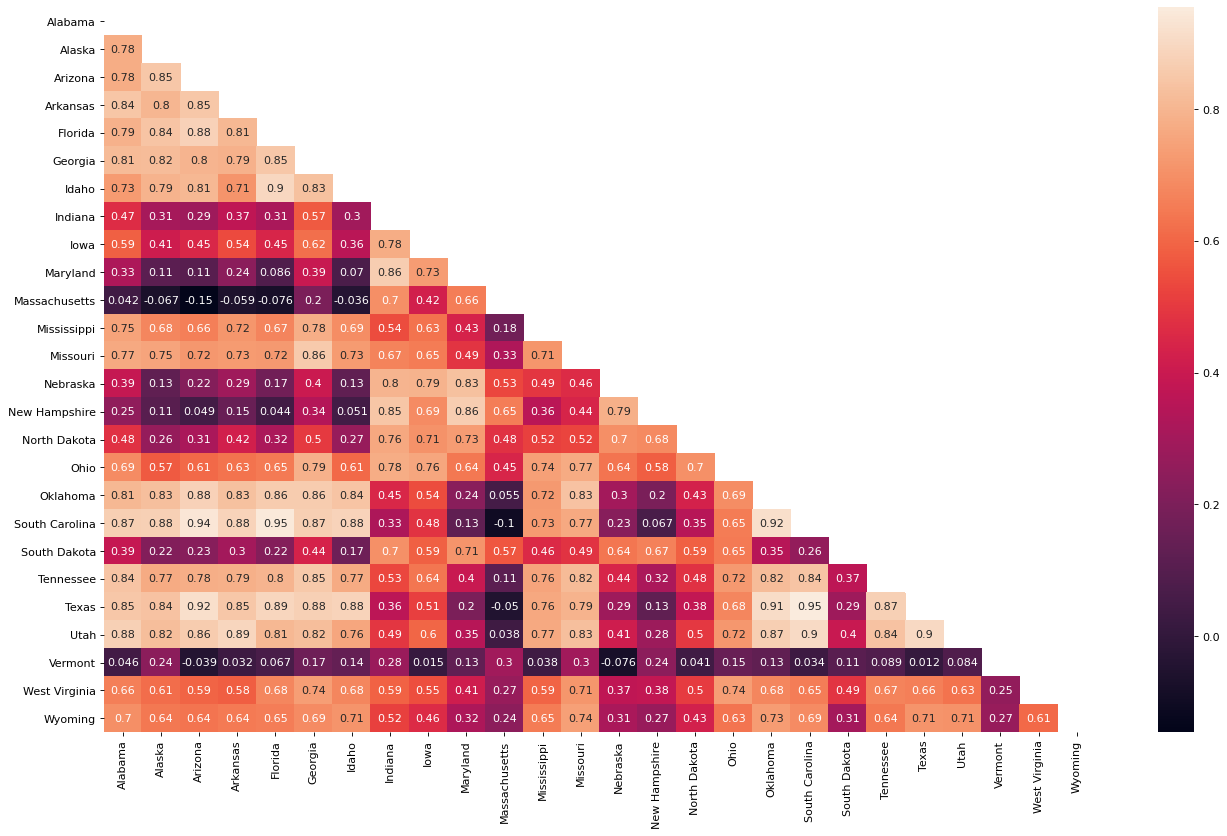

In [53]:
#sns.heatmap(overall_pearson_r)
import numpy as np
fig=plt.figure(figsize=(20, 12), dpi= 80, facecolor='w', edgecolor='k')

matrix = np.triu(overall_pearson_r)
sns.heatmap(overall_pearson_r, annot=True, mask=matrix)